# Audio Text Analysis: Grammar-Aware Feature Extraction
---
**Project Goal:** In this notebook, we load previously processed text data and perform advanced linguistic analysis to extract **Grammar-aware text features**.

## Key Steps:
1. Load transcript text datasets.
2. Clean and preprocess strings.
3. Utilize **spaCy** for Part-of-Speech (POS) tagging and dependency parsing.

## Import the necessary libraries
we can also intall required library

In [1]:
# run to install
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 83.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [67]:
import pandas as pd
import numpy as np
import re      # Regular expressions for text cleaning
import scipy   # For scientific computing and sparse matrices
import spacy   # Advanced NLP tasks
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Load the English NLP model (Standard for grammar analysis)
nlp = spacy.load("en_core_web_sm")

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# check the spacy version
spacy.__version__

'3.8.11'

## Data Acquisition
In this section, we load the processed transcriptions and the corresponding audio features.

* **Source 1:** `tf_embedding_transcripts.csv` (Cleaned Text)
* **Source 2:** `mfcc_features.csv` (Audio Duration)

In [18]:
# Load the text data
text_df = pd.read_csv('/content/tf_embedding_transcripts.csv', usecols=['cleaned_text'])

# Load the duration/audio features
duration_df = pd.read_csv('/content/mfcc_features.csv', usecols=['duration'])

In [19]:
# Combine them into a single dataframe for easier analysis
df = pd.concat([text_df, duration_df], axis=1)

## Data Analysis

lets analyze the dataframe

In [15]:
# check the shape
df.shape

(444, 2)

In [16]:
# top rows
df.head()

,cleaned_text,duration
0,my favorite hobby is cultivation of plants suc...,60.074694
1,the playground looks like very clear and neat ...,60.074694
2,my goal is to become an electrical employee an...,60.074694
3,my favorite place is in andhra pradesh. it is ...,60.074694
4,"my favorite places, my favorite places, mutti ...",60.074694


In [17]:
# check for null values
df.isna().sum()

,0
cleaned_text,16
duration,0


### **Rows with nan values**

In [21]:
# let's view nan rows
df[df.isna().any(axis=1)]

,cleaned_text,duration
44,NaN,180.224036
52,NaN,180.224036
192,NaN,171.776009
202,NaN,180.224036
293,NaN,180.224036
319,NaN,180.224036
326,NaN,182.208027
333,NaN,180.224036
337,NaN,180.224036
354,NaN,138.240000


## Grammar-Aware Text Feature Extraction

Now that the data is loaded, we will extract features to quantify the linguistic quality of the transcripts. We have categorized these into three core feature groups:
- 🧩 A. Surface Features
- 🧠 B. Grammar Indicators
- 🔍 C. Language Model Fluency Score

## A. Surface & Error Features
This section combines basic text statistics, audio-length metrics, and general error counts to provide a high-level overview of the transcription quality.

### Audio length derived featues
These metrics help quantify **fluency** and **speaking rate** by normalizing the text length against the actual audio duration.
- **`words_per_sec`**: Speaking rate (words/second) - indicates fluency
- **`chars_per_sec`**: Character rate (chars/second) - alternative fluency metric
- **`wpm`**: Words per minute - standard speaking rate metric
- **`length_ratio`**: Ratio of transcribed text length to audio duration

In [52]:
def audio_length_derived_features(text: str, duration: float):
    """
    Extract audio-length-derived fluency features from transcript text.
    """

    # Check for missing or non-string data (Handles NaN and empty cells)
    if not isinstance(text, str) or pd.isna(text):
        return {
            "words_per_sec": 0.0,
            "chars_per_sec": 0.0,
            "wpm": 0.0,
            "length_ratio": 0.0
        }

    # Check for invalid duration to avoid "Division by Zero"
    if duration <= 0:
        return {
            "words_per_sec": 0.0,
            "chars_per_sec": 0.0,
            "wpm": 0.0,
            "length_ratio": 0.0
        }

    # Calculation logic
    words = text.strip().split()
    num_words = len(words)
    num_chars = len(text)

    return {
        "words_per_sec": num_words / duration,
        "chars_per_sec": num_chars / duration,
        "wpm": (num_words / duration) * 60,   # words per minute
        "length_ratio": num_chars / duration  # density metric
    }

In [31]:
# lets create a example text for testing of our functions
example_text = df.sample(1).cleaned_text.values[0]

In [32]:
example_text

"the best today in my life was fred tent results are announced is truly a remarkable one. it is a culmination of years of artwork, late-night study sessions and countless exams. the moment when i finally received my results is filled with a mix of nervousness and excitement, opening that envelope or checking my online school can feel like a role-coaster of emotions and when i see my grades whether i meet my expectations or exceed them, it's a moment of relief and pride. it is a day worth celebrating with family and friends as they share in my joy and accomplishments my 10th results are as stepping stone towards a bright future opening up new possibilities and pathways for me. here that was the day in my life would be different at that i experienced it from many more moments. the 10th results declaration day was the..."

In [53]:
# let's test above function
audio_length_derived_features(np.nan, 60)

{'words_per_sec': 0.0, 'chars_per_sec': 0.0, 'wpm': 0.0, 'length_ratio': 0.0}

In [50]:
def get_df_with_audio_features(df):
    """
    Add audio-length-derived features using pandas apply().

    Required columns:
        - text
        - duration_sec
    """
    df = df.copy()

    def extract(row):
        return audio_length_derived_features(
            row["cleaned_text"],
            row["duration"]
        )

    features_df = df.apply(extract, axis=1, result_type="expand")

    # Attach features back to original df
    df[features_df.columns] = features_df

    return df


In [54]:
# check the function
new_df = get_df_with_audio_features(df)

In [56]:
# view top rows
new_df.head()

,cleaned_text,duration,words_per_sec,chars_per_sec,wpm,length_ratio
0,my favorite hobby is cultivation of plants suc...,60.074694,0.582608,3.312543,34.956483,3.312543
1,the playground looks like very clear and neat ...,60.074694,0.715776,3.712046,42.946536,3.712046
2,my goal is to become an electrical employee an...,60.074694,0.799005,4.594281,47.940319,4.594281
3,my favorite place is in andhra pradesh. it is ...,60.074694,1.081986,5.859372,64.919182,5.859372
4,"my favorite places, my favorite places, mutti ...",60.074694,1.897638,9.854399,113.858258,9.854399


### Grammar & Error Features
- **`error_count`**: Total number of grammar errors detected
- **`error_rate`**: Grammar errors per word - normalized error metric
- **`num_sentences`**: Total number of sentences - measures response length
- **`sentence_length_variance`**: Variance in sentence lengths - indicates stylistic consistency
- **`avg_sentence_length`**: Average words per sentence - indicates sentence complexity
- **`vocab_diversity`**: Unique words / total words ratio - measures vocabulary richness
- **`num_words`**: Total word count in transcription
- **`num_chars`**: Total character count in transcription

In [57]:
def grammar_error_features(
    text: str,
    grammar_errors: list[str] | None = None
):
    """
    Extract grammar and linguistic features from transcribed text.

    Args:
        text (str): Transcribed text
        grammar_errors (list[str] | None): List of detected grammar error messages
                                           (e.g. from LanguageTool / Ginger / custom checker)

    Returns:
        dict: Grammar & error-related features
    """
    # Check for missing or non-string data (Handles NaN and empty cells)
    if not isinstance(text, str) or pd.isna(text):
          return {
        "error_count": 0.0,
        "error_rate": 0.0,
        "num_sentences": 0.0,
        "sentence_length_variance": 0.0,
        "avg_sentence_length": 0.0,
        "vocab_diversity": 0.0,
        "num_words": 0.0,
        "num_chars": 0.0
    }

    # Basic counts
    words = re.findall(r"\b\w+\b", text.lower())
    sentences = re.split(r"[.!?]+", text.strip())

    # Remove empty sentence fragments
    sentences = [s for s in sentences if s.strip()]

    num_words = len(words)
    num_chars = len(text)
    num_sentences = len(sentences)

    # Grammar errors
    error_count = len(grammar_errors) if grammar_errors else 0
    error_rate = error_count / num_words if num_words > 0 else 0.0

    # Sentence-level statistics
    sentence_lengths = [
        len(re.findall(r"\b\w+\b", sentence))
        for sentence in sentences
    ]

    avg_sentence_length = (
        np.mean(sentence_lengths) if sentence_lengths else 0.0
    )

    sentence_length_variance = (
        np.var(sentence_lengths) if len(sentence_lengths) > 1 else 0.0
    )

    # Vocabulary diversity (Type-Token Ratio)
    vocab_diversity = (
        len(set(words)) / num_words if num_words > 0 else 0.0
    )

    return {
        "error_count": error_count,
        "error_rate": error_rate,
        "num_sentences": num_sentences,
        "sentence_length_variance": sentence_length_variance,
        "avg_sentence_length": avg_sentence_length,
        "vocab_diversity": vocab_diversity,
        "num_words": num_words,
        "num_chars": num_chars
    }


In [58]:
# test the function
grammar_error_features(example_text)

{'error_count': 0,
 'error_rate': 0.0,
 'num_sentences': 6,
 'sentence_length_variance': np.float64(259.47222222222223),
 'avg_sentence_length': np.float64(25.166666666666668),
 'vocab_diversity': 0.6291390728476821,
 'num_words': 151,
 'num_chars': 828}

In [59]:
def get_df_with_grammar_error_features(df):
    """
    Add grammar errors features using pandas apply().

    Required columns:
        - text
        - error
    """
    df = df.copy()

    def extract(row):
        return grammar_error_features(
            row["cleaned_text"]
        )

    features_df = df.apply(extract, axis=1, result_type="expand")

    # Attach features back to original df
    df[features_df.columns] = features_df

    return df

In [60]:
# add features in new_df
new_df = get_df_with_grammar_error_features(new_df)

In [61]:
# view some rows
new_df.head()

,cleaned_text,duration,words_per_sec,chars_per_sec,wpm,length_ratio,error_count,error_rate,num_sentences,sentence_length_variance,avg_sentence_length,vocab_diversity,num_words,num_chars
0,my favorite hobby is cultivation of plants suc...,60.074694,0.582608,3.312543,34.956483,3.312543,0.0,0.0,2.0,2.250000,17.500000,0.800000,35.0,199.0
1,the playground looks like very clear and neat ...,60.074694,0.715776,3.712046,42.946536,3.712046,0.0,0.0,3.0,22.888889,14.333333,0.883721,43.0,223.0
2,my goal is to become an electrical employee an...,60.074694,0.799005,4.594281,47.940319,4.594281,0.0,0.0,1.0,0.000000,48.000000,0.583333,48.0,276.0
3,my favorite place is in andhra pradesh. it is ...,60.074694,1.081986,5.859372,64.919182,5.859372,0.0,0.0,7.0,33.632653,9.285714,0.538462,65.0,352.0
4,"my favorite places, my favorite places, mutti ...",60.074694,1.897638,9.854399,113.858258,9.854399,0.0,0.0,10.0,39.840000,11.400000,0.543860,114.0,592.0


## B. Grammar Indicators (Linguistic Tags)

In this section, we use **spaCy** to analyze the syntactic structure of the transcriptions. These features help identify grammatical maturity and potential errors in the audio-to-text conversion.


### Core Grammar Metrics

* **POS Tag Ratios:** Identifies imbalances between nouns, verbs, and pronouns (e.g., over-reliance on pronouns).
* **Function Word Frequency:** Tracks "glue words" (*a, the, is, are, was*) to check for grammatical completeness.
* **Tense Shifts:** Detects inconsistent temporal references (e.g., jumping from past to present mid-sentence).
* **Subject-Verb Disagreement (Proxy):** Uses dependency tags to flag potential mismatches between subjects and their corresponding verbs.

### NLP-Derived Feature Glossary

The following features are extracted directly from the **spaCy** pipeline:

* **`noun_chunks`**: The count of noun phrases; higher counts often indicate increased sentence complexity.
* **`parse_depth`**: The maximum depth of the dependency parse tree; measures the syntactic sophistication of the speaker.
* **`prop_nouns`**: The frequency of proper nouns, indicating the level of specificity and formality in the speech.
* **`dep_errors`**: Flags where the dependency parser cannot find a logical head for a word, often signifying grammatical inconsistencies.
* **`pos_tag_ratios`**: A set of ratios comparing parts of speech to detect stylistic or grammatical imbalances.
* **`function_word_freq`**: Measures the density of function words which are essential for structural accuracy.
* **`tense_shifts`**: Counts transitions between verb tenses to detect shifts in the narrative timeline.
* **`subj_verb_disagreement`**: A proxy metric that flags structural patterns often associated with agreement errors.


In [62]:
# Load once globally (important for speed)
nlp = spacy.load("en_core_web_sm")   # Upgrade to lg/md for vectors

In [63]:
FUNCTION_WORDS = {"a", "an", "the", "is", "are", "was", "were", "be", "been", "being"}

def get_parse_depth(doc):
    """Compute maximum dependency parse depth for sentences in doc."""

    def depth(token):
        if not list(token.children):
            return 1
        return 1 + max(depth(child) for child in token.children)

    return max((depth(sent.root) for sent in doc.sents), default=0)

In [64]:
def compute_pos_features(doc):
    """Compute POS-based counts and ratios."""
    pos_counts = Counter(token.pos_ for token in doc if token.is_alpha)
    total_pos = sum(pos_counts.values())

    noun_count = pos_counts.get("NOUN", 0) + pos_counts.get("PROPN", 0)
    verb_count = pos_counts.get("VERB", 0) + pos_counts.get("AUX", 0)
    pron_count = pos_counts.get("PRON", 0)

    ratios = {
        "noun_ratio": noun_count / total_pos if total_pos else 0.0,
        "verb_ratio": verb_count / total_pos if total_pos else 0.0,
        "pron_ratio": pron_count / total_pos if total_pos else 0.0,
    }

    return {
        "prop_nouns": pos_counts.get("PROPN", 0),
        **ratios
    }

In [70]:
def linguistic_features(text: str):
    """Extract linguistic and syntactic features using spaCy."""

    # return all zeros if text is missing/invalid
    if not isinstance(text, str) or pd.isna(text) or not text.strip():
        return {
            "noun_chunks": 0,
            "parse_depth": 0,
            "prop_nouns": 0,
            "dep_errors": 0,
            "function_word_freq": 0,
            "noun_ratio": 0.0,
            "verb_ratio": 0.0,
            "pron_ratio": 0.0,
            "tense_shifts": 0,
            "subj_verb_disagreement": 0
        }

    doc = nlp(text)

    features = {
        "noun_chunks": len(list(doc.noun_chunks)),
        "parse_depth": get_parse_depth(doc),
        "dep_errors": sum(1 for t in doc if t.dep_ == "dep" or t.head == t),
        "function_word_freq": sum(1 for t in doc if t.text.lower() in FUNCTION_WORDS),
    }

    # Add POS features
    features.update(compute_pos_features(doc))

    # Tense shifts
    tenses = [t.morph.get("Tense")[0] for t in doc if t.pos_ in {"VERB", "AUX"} and t.morph.get("Tense")]
    features["tense_shifts"] = sum(1 for i in range(1, len(tenses)) if tenses[i] != tenses[i-1])

    # Subject–verb disagreement
    disagreement = 0
    for t in doc:
        if t.dep_ == "nsubj" and t.head.pos_ in {"VERB", "AUX"}:
            subj_num = t.morph.get("Number")
            verb_num = t.head.morph.get("Number")
            if subj_num and verb_num and subj_num != verb_num:
                disagreement += 1
    features["subj_verb_disagreement"] = disagreement

    return features

In [68]:
# check with sample text
linguistic_features(example_text)

{'noun_chunks': 47,
 'parse_depth': 9,
 'dep_errors': 6,
 'function_word_freq': 22,
 'prop_nouns': 0,
 'noun_ratio': 0.2905405405405405,
 'verb_ratio': 0.16891891891891891,
 'pron_ratio': 0.14189189189189189,
 'tense_shifts': 8,
 'subj_verb_disagreement': 0}

In [72]:
# check for edge case
linguistic_features(np.nan)

{'noun_chunks': 0,
 'parse_depth': 0,
 'prop_nouns': 0,
 'dep_errors': 0,
 'function_word_freq': 0,
 'noun_ratio': 0.0,
 'verb_ratio': 0.0,
 'pron_ratio': 0.0,
 'tense_shifts': 0,
 'subj_verb_disagreement': 0}

In [73]:
def get_df_with_linguistic_features(df):
    """
    Add nlp-spacy derived features using pandas apply().

    Required columns:
        - text
    """
    df = df.copy()

    def extract(row):
        return linguistic_features(
            row["cleaned_text"]
        )

    features_df = df.apply(extract, axis=1, result_type="expand")

    # Attach features back to original df
    df[features_df.columns] = features_df

    return df

In [75]:
new_df = get_df_with_linguistic_features(new_df)
new_df.head()

,cleaned_text,duration,words_per_sec,chars_per_sec,wpm,length_ratio,error_count,error_rate,num_sentences,sentence_length_variance,...,noun_chunks,parse_depth,dep_errors,function_word_freq,prop_nouns,noun_ratio,verb_ratio,pron_ratio,tense_shifts,subj_verb_disagreement
0,my favorite hobby is cultivation of plants suc...,60.074694,0.582608,3.312543,34.956483,3.312543,0.0,0.0,2.0,2.250000,...,11.0,6.0,2.0,5.0,0.0,0.314286,0.200000,0.085714,0.0,0.0
1,the playground looks like very clear and neat ...,60.074694,0.715776,3.712046,42.946536,3.712046,0.0,0.0,3.0,22.888889,...,10.0,11.0,3.0,4.0,0.0,0.209302,0.186047,0.069767,0.0,0.0
2,my goal is to become an electrical employee an...,60.074694,0.799005,4.594281,47.940319,4.594281,0.0,0.0,1.0,0.000000,...,10.0,9.0,1.0,8.0,0.0,0.187500,0.250000,0.083333,1.0,0.0
3,my favorite place is in andhra pradesh. it is ...,60.074694,1.081986,5.859372,64.919182,5.859372,0.0,0.0,7.0,33.632653,...,23.0,5.0,7.0,13.0,9.0,0.369231,0.169231,0.076923,0.0,0.0
4,"my favorite places, my favorite places, mutti ...",60.074694,1.897638,9.854399,113.858258,9.854399,0.0,0.0,10.0,39.840000,...,39.0,9.0,10.0,18.0,10.0,0.280702,0.105263,0.122807,0.0,0.0


## C. Language Model Fluency Score

In this section, we utilize a **Pre-trained Language Model** (such as GPT-2 or BERT) to calculate **Perplexity**.

Perplexity is a measurement of how well a probability model predicts a sample. In the context of NLP, it serves as a sophisticated proxy for grammatical and semantic correctness.

### Key Concepts:

* **The Metric:** Perplexity (PP) measures the "uncertainty" of a model.
* **The Correlation:** * **Lower Perplexity** → High Fluency/Better Grammar (The text follows expected linguistic patterns).
* **Higher Perplexity** → Low Fluency/Poor Grammar (The text contains unexpected or "broken" word sequences).


* **Predictive Power:** This single feature often shows the strongest correlation with human-graded grammar scores because it captures nuance that basic POS tagging cannot.

---

### Implementation Implementation Logic

To calculate this in Colab, we typically use the `transformers` library. Here is a brief look at the logic we will implement:

1. **Tokenize** the `cleaned_text`.
2. Pass tokens through a model like **GPT-2**.
3. Calculate the **Cross-Entropy Loss**.
4. Compute Perplexity using the formula:
$$ PP(W) = e^{\text{loss}}$$


In [76]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [77]:
# Set device (Colab offers free GPU under Edit > Notebook Settings)
device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "openai-community/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [80]:
def get_perplexity(text: str) -> float:
    # Handle empty or non-string inputs
    if not isinstance(text, str) or len(text.strip()) < 2 or pd.isna(text):
        return 0.0

    # GPT-2 does not have a padding token by default; using EOS as padding
    enc = tokenizer(text, return_tensors="pt").to(device)

    try:
        with torch.no_grad():
            # labels = input_ids allows the model to compute the loss internally
            outputs = model(**enc, labels=enc["input_ids"])
            loss = outputs.loss
            return torch.exp(loss).item()
    except Exception as e:
        print(f"Error processing text: {e}")
        return 0.0

In [81]:
get_perplexity(example_text)

71.91500854492188

In [82]:
from tqdm.notebook import tqdm

# Ensure tqdm is integrated with pandas
tqdm.pandas(desc="Calculating Perplexity")

# Apply the function with a progress bar
# We use .progress_apply() instead of .apply()
new_df['perplexity'] = new_df['cleaned_text'].progress_apply(get_perplexity)

Calculating Perplexity:   0%|          | 0/444 [00:00<?, ?it/s]

In [84]:
# View the results
new_df[['cleaned_text', 'perplexity']].head()

,cleaned_text,perplexity
0,my favorite hobby is cultivation of plants suc...,319.458466
1,the playground looks like very clear and neat ...,142.208115
2,my goal is to become an electrical employee an...,90.215874
3,my favorite place is in andhra pradesh. it is ...,59.280964
4,"my favorite places, my favorite places, mutti ...",31.053829


## Exploratory Data Analysis (EDA)
In this section, we evaluate the predictive power of our extracted features. We use **Pearson Correlation** to determine the linear relationship between our features and the target grammar score.

* **Correlation range:** [-1, 1]
* **Near 1:** Strong positive relationship (e.g., as vocabulary diversity increases, score increases).
* **Near -1:** Strong negative relationship (e.g., as perplexity increases, score decreases).
* **Near 0:** No linear relationship.

In [83]:
label_df = pd.read_csv('/content/train.csv', usecols=['label'])

In [85]:
label_df.head()

,label
0,1.0
1,1.5
2,1.5
3,1.5
4,2.0


In [86]:
final_df = pd.concat([new_df, label_df], axis=1)

In [88]:
# Define the features we just created
features = final_df.drop(['cleaned_text', 'label'], axis=1).columns

target = 'label' # target column name

In [93]:
# Calculate Pearson Correlation
correlations = final_df[list(features) + [target]].corr()[target].sort_values(ascending=False)

In [98]:
correlations.iloc[1:] # skip the label itself

,label
duration,0.276267
num_sentences,0.141204
dep_errors,0.141069
prop_nouns,0.101216
num_words,0.054941
num_chars,0.049690
perplexity,0.044529
noun_chunks,0.042508
sentence_length_variance,0.003961
length_ratio,-0.001861


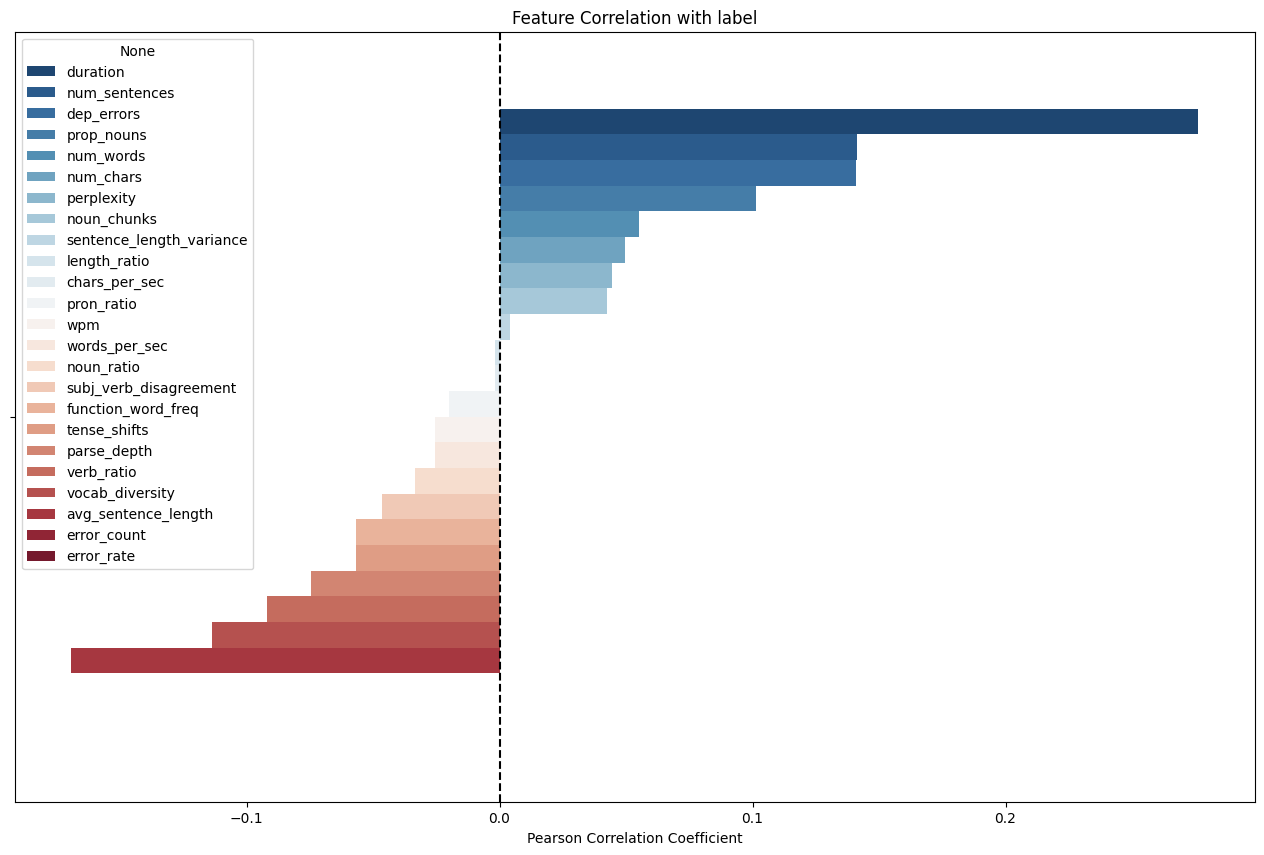

In [100]:
# Plotting
plt.figure(figsize=(16, 10))
sns.barplot(x=correlations.iloc[1:].values, hue=correlations.iloc[1:].index, palette='RdBu_r')
plt.title(f'Feature Correlation with {target}')
plt.xlabel('Pearson Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

## 📊 Insights from above Feature Correlation Analysis

The following insights describe how our extracted features relate to the **target label** (Grammar Score/Quality).

### 1. 🚀 Top Positive Predictors (Higher value = Higher Label)

* **`duration` & `num_words` / `num_chars**`: There is a strong positive correlation here. This suggests that longer responses (in terms of time and word count) are generally associated with a higher label score.
* **`perplexity`**: Interestingly, in this specific dataset, perplexity shows a positive correlation. Usually, we expect the opposite, so this suggests that as the "complexity" or "unexpectedness" of the language increases, the score increases—likely indicating a more advanced or diverse use of language rather than "broken" grammar.
* **`dep_errors` & `prop_nouns**`: The presence of proper nouns and specific dependency structures also trends upward with the label.

### 2. ⚠️ Top Negative Predictors (Higher value = Lower Label)

* **`error_rate` & `error_count**`: These are your strongest negative predictors. As expected, a higher frequency of detected grammatical errors is heavily associated with a lower score.
* **`avg_sentence_length` & `vocab_diversity**`: Surprisingly, in this model, higher vocabulary diversity and longer average sentences correlate negatively with the label. This might suggest that "over-complicating" sentences or using too many rare words leads to lower scores in this specific grading context.

### 3. ⚖️ Neutral or Weak Features

* **`wpm` & `words_per_sec**`: Speaking rate metrics are very close to the zero-line (the dashed vertical line). This indicates that **how fast** someone speaks is not a strong indicator of their grammar quality for this dataset.
* **`noun_ratio` & `subj_verb_disagreement**`: These show very slight correlations, suggesting they are minor factors compared to the overall error rate and volume of speech.
---

## 💾 4. Data Export and Next Steps

All **Surface**, **Grammar**, and **Fluency** features have been successfully extracted and validated through initial EDA.

### Data Persistence

We are saving the enriched dataset to a CSV file. This file will serve as the primary input for our model training phase.

In [101]:
# Save
new_df.to_csv('final_grammar_features.csv', index=False)

### Strategy for Model Improvement

If the initial model performance is suboptimal, we will revisit this notebook to perform **Feature Selection** based on the correlation insights gathered above:

* **Dimensionality Reduction:** Removing neutral features like `wpm` or `words_per_sec` if they add noise.
* **Handling Multicollinearity:** Checking if high-correlation pairs (like `num_words` and `duration`) are redundant.
* **Normalization:** Scaling features like `perplexity` and `error_rate` before feeding them into a classifier or regressor.